In [1]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
from PIL import Image
from torchvision import models, transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset, random_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import time
from sklearn.metrics import f1_score
import timm
%pip install -U git+https://github.com/szagoruyko/pytorchviz.git@master
from torchviz import make_dot

  Cloning https://github.com/szagoruyko/pytorchviz.git (to revision master) to /tmp/pip-req-build-gewmotje
  Running command git clone --filter=blob:none --quiet https://github.com/szagoruyko/pytorchviz.git /tmp/pip-req-build-gewmotje
  Resolved https://github.com/szagoruyko/pytorchviz.git to commit 0adcd83af8aa7ab36d6afd139cabbd9df598edb7
  Preparing metadata (setup.py) ... done
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4973 sha256=a1f1a40315c2e0a473b8ded639bf9c46ef02d51ad45db6ed28ad1b59c45416fd
  Stored in directory: /tmp/pip-ephem-wheel-cache-8gmg4ibd/wheels/97/11/17/d09e895f9883bd50923ce86b249a31790356a1b88b280983d8
Successfully built torchviz
Note: you may need to restart the kernel to use updated packages.


In [2]:
# Load and preview the dataset
train = pd.read_csv('/kaggle/input/jutepest/train.csv')
train.head()

,filename,class
0,data_813.jpg,Jute Stem Weevil
1,data_6274.jpg,Mealybug
2,data_2317.jpg,Black Hairy
3,data_2124.jpg,Termite
4,data_5974.jpg,Jute Aphid


In [3]:
# Encode class labels to integers
label_encoder = LabelEncoder()
train['class'] = label_encoder.fit_transform(train['class'])

In [4]:
# Define the image transformation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    transforms.ToTensor(),
])


In [5]:
# Define custom dataset class
class JutePestDataset(Dataset):
    def __init__(self, dataframe, img_dir, transform=None):
        self.dataframe = dataframe
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir, self.dataframe.iloc[idx, 0])
        image = Image.open(img_name).convert('RGB')

        if self.transform:
            image = self.transform(image)

        label = self.dataframe.iloc[idx, 1]
        label = torch.tensor(label, dtype=torch.long)

        return image, label

In [6]:
# Create dataset and split into training and validation sets
train_dir = '/kaggle/input/jutepest/train_images/'
dataset = JutePestDataset(train, train_dir, transform)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

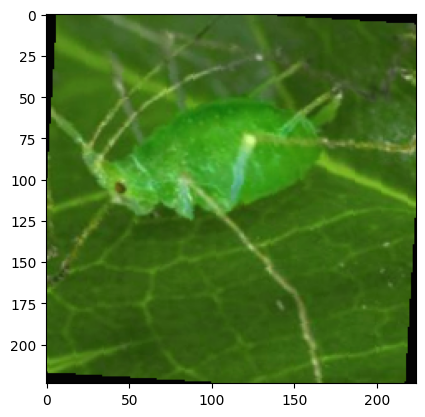

In [7]:
# Display a sample image
plt.imshow(torch.permute(dataset[4][0], (1, 2, 0)))
plt.show()

In [8]:
# Create DataLoader instances
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

### XCeption


In [9]:
# Define a custom model using Xception from timm
class CustomXception(nn.Module):
    def __init__(self, num_classes):
        super(CustomXception, self).__init__()
        self.model = timm.create_model('legacy_xception', pretrained=False, num_classes=num_classes)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.model(x)
        x = self.dropout(x)
        return x

In [10]:
# Initialize the model, loss function, optimizer, and learning rate scheduler
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CustomXception(num_classes=17).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)  # L2 regularization
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.75)

In [11]:
# Print model summary
from torchinfo import summary
summary(model, (32, 3, 224, 224))

Layer (type:depth-idx)                        Output Shape              Param #
CustomXception                                [32, 17]                  --
├─Xception: 1-1                               [32, 17]                  --
│    └─Conv2d: 2-1                            [32, 32, 111, 111]        864
│    └─BatchNorm2d: 2-2                       [32, 32, 111, 111]        64
│    └─ReLU: 2-3                              [32, 32, 111, 111]        --
│    └─Conv2d: 2-4                            [32, 64, 109, 109]        18,432
│    └─BatchNorm2d: 2-5                       [32, 64, 109, 109]        128
│    └─ReLU: 2-6                              [32, 64, 109, 109]        --
│    └─Block: 2-7                             [32, 128, 55, 55]         --
│    │    └─Sequential: 3-1                   [32, 128, 55, 55]         26,816
│    │    └─Conv2d: 3-2                       [32, 128, 55, 55]         8,192
│    │    └─BatchNorm2d: 3-3                  [32, 128, 55, 55]         256
│    └

In [12]:
# dummy input untuk memvisualisasikan arsitektur
dummy_input = torch.randn(1, 3, 299, 299).to(device)
y = model(dummy_input)
dot = make_dot(y, params=dict(model.named_parameters()), show_attrs=False, show_saved=False)
dot.format = 'png'
dot.render('model_architecture_torchviz')
torch.onnx.export(model, dummy_input, "model.onnx", verbose=False)


In [13]:
# Determine the device to use
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
torch.cuda.empty_cache()
model.to(device)

CustomXception(
  (model): Xception(
    (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act1): ReLU(inplace=True)
    (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act2): ReLU(inplace=True)
    (block1): Block(
      (skip): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2), bias=False)
      (skipbn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (rep): Sequential(
        (0): SeparableConv2d(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
          (pointwise): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        )
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inpl

In [14]:
# Fungsi untuk menghitung akurasi
def calc_accuracy(true, pred):
    pred = F.softmax(pred, dim=1)
    acc = (true == pred.argmax(dim=1)).float().mean().item()
    return round(acc * 100, 2)

In [15]:
# Fungsi untuk menghitung F1 Score
def calc_f1_score(true, pred):
    pred = F.softmax(pred, dim=1).argmax(dim=1)
    true = true.cpu().numpy()
    pred = pred.cpu().numpy()
    return f1_score(true, pred, average='weighted')

## Melanjutkan Epoch Sebelumnya


In [16]:
checkpoint_path = ''

# Check if checkpoint exists
if os.path.exists(checkpoint_path) and checkpoint_path:
    # Load the checkpoint
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch']
    best_val_loss = checkpoint['best_val_loss']
    patience_counter = checkpoint['patience_counter']
    train_loss = checkpoint['train_loss']
    train_accuracy = checkpoint['train_accuracy']
    train_f1_score = checkpoint['train_f1_score']
    val_loss = checkpoint['val_loss']
    val_accuracy = checkpoint['val_accuracy']
    val_f1_score = checkpoint['val_f1_score']
    print(f"Checkpoint loaded, starting from epoch {start_epoch}")
else:
    # Initialize training and validation statistics
    start_epoch = 0
    best_val_loss = np.inf
    patience_counter = 0
    train_loss = []
    train_accuracy = []
    train_f1_score = []
    val_loss = []
    val_accuracy = []
    val_f1_score = []
    print("No checkpoint found, starting from scratch")

No checkpoint found, starting from scratch


## Training

In [17]:
# Initialize training and validation statistics
epochs = 100
patience = 7

In [18]:
# Training loop
for epoch in range(start_epoch, epochs):
    start_time = time.time()
    train_epoch_loss = []
    train_epoch_accuracy = []
    train_epoch_f1_score = []
    val_epoch_loss = []
    val_epoch_accuracy = []
    val_epoch_f1_score = []

    model.train()
    with tqdm(total=len(train_loader), desc=f"Epoch {epoch + 1}/{epochs}", unit='batch') as pbar:
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            preds = model(images)
            acc = calc_accuracy(labels, preds)
            f1 = calc_f1_score(labels, preds)
            loss = criterion(preds, labels)
            loss.backward()
            optimizer.step()

            train_epoch_loss.append(loss.item())
            train_epoch_accuracy.append(acc)
            train_epoch_f1_score.append(f1)

            pbar.set_postfix({'Training Loss': np.mean(train_epoch_loss), 'Training Accuracy': np.mean(train_epoch_accuracy), 'Training F1 Score': np.mean(train_epoch_f1_score)})
            pbar.update(1)

    model.eval()
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            preds = model(images)
            acc = calc_accuracy(labels, preds)
            f1 = calc_f1_score(labels, preds)
            loss = criterion(preds, labels)

            val_epoch_loss.append(loss.item())
            val_epoch_accuracy.append(acc)
            val_epoch_f1_score.append(f1)

    train_epoch_loss = np.mean(train_epoch_loss)
    train_epoch_accuracy = np.mean(train_epoch_accuracy)
    train_epoch_f1_score = np.mean(train_epoch_f1_score)
    val_epoch_loss = np.mean(val_epoch_loss)
    val_epoch_accuracy = np.mean(val_epoch_accuracy)
    val_epoch_f1_score = np.mean(val_epoch_f1_score)

    train_loss.append(train_epoch_loss)
    train_accuracy.append(train_epoch_accuracy)
    train_f1_score.append(train_epoch_f1_score)
    val_loss.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)
    val_f1_score.append(val_epoch_f1_score)

    end_time = time.time()
    epoch_duration = end_time - start_time

    print(f"Epoch {epoch + 1}/{epochs}, Training Loss: {train_epoch_loss:.4f}, Training Accuracy: {train_epoch_accuracy:.2f}%, Training F1 Score: {train_epoch_f1_score:.2f}")
    print(f"Validation Loss: {val_epoch_loss:.4f}, Validation Accuracy: {val_epoch_accuracy:.2f}%, Validation F1 Score: {val_epoch_f1_score:.2f}, Epoch Duration: {epoch_duration:.2f} seconds")

    # Save the model and optimizer state every 10 epochs
    if (epoch + 1) % 10 == 0 or (epoch + 1) == epochs:
        checkpoint = {
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'best_val_loss': best_val_loss,
            'patience_counter': patience_counter,
            'train_loss': train_loss,
            'train_accuracy': train_accuracy,
            'train_f1_score': train_f1_score,
            'val_loss': val_loss,
            'val_accuracy': val_accuracy,
            'val_f1_score': val_f1_score
        }
        torch.save(checkpoint, f'checkpoint_epoch_{epoch + 1}.pth')
        print(f'Model saved at epoch {epoch + 1}')

    if val_epoch_loss < best_val_loss:
        best_val_loss = val_epoch_loss
        patience_counter = 0
        checkpoint_best = {
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'best_val_loss': best_val_loss,
            'patience_counter': patience_counter,
            'train_loss': train_loss,
            'train_accuracy': train_accuracy,
            'train_f1_score': train_f1_score,
            'val_loss': val_loss,
            'val_accuracy': val_accuracy,
            'val_f1_score': val_f1_score
        }
        torch.save(checkpoint_best, 'checkpoint_best.pth')
        torch.save(model.state_dict(), 'best_xception_model.pth')
        print('Best model saved')
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered")
            checkpoint = {
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'best_val_loss': best_val_loss,
                'patience_counter': patience_counter,
                'train_loss': train_loss,
                'train_accuracy': train_accuracy,
                'train_f1_score': train_f1_score,
                'val_loss': val_loss,
                'val_accuracy': val_accuracy,
                'val_f1_score': val_f1_score
            }
            torch.save(checkpoint, f'checkpoint_epoch_{epoch + 1}.pth')
            print(f'Model saved at epoch {epoch + 1} due to early stopping')
            break

    lr_scheduler.step()

Epoch 1/100: 100%|██████████| 154/154 [02:00<00:00,  1.27batch/s, Training Loss=2.56, Training Accuracy=19.8, Training F1 Score=0.191]


Epoch 1/100, Training Loss: 2.5575, Training Accuracy: 19.77%, Training F1 Score: 0.19
Validation Loss: 2.2364, Validation Accuracy: 33.34%, Validation F1 Score: 0.30, Epoch Duration: 142.48 seconds
Best model saved


Epoch 2/100: 100%|██████████| 154/154 [01:36<00:00,  1.60batch/s, Training Loss=2.33, Training Accuracy=26.4, Training F1 Score=0.264]


Epoch 2/100, Training Loss: 2.3332, Training Accuracy: 26.35%, Training F1 Score: 0.26
Validation Loss: 1.8807, Validation Accuracy: 46.34%, Validation F1 Score: 0.42, Epoch Duration: 111.61 seconds
Best model saved


Epoch 3/100: 100%|██████████| 154/154 [01:36<00:00,  1.60batch/s, Training Loss=2.22, Training Accuracy=29.3, Training F1 Score=0.306]


Epoch 3/100, Training Loss: 2.2165, Training Accuracy: 29.34%, Training F1 Score: 0.31
Validation Loss: 1.6722, Validation Accuracy: 50.07%, Validation F1 Score: 0.48, Epoch Duration: 111.76 seconds
Best model saved


Epoch 4/100: 100%|██████████| 154/154 [01:36<00:00,  1.59batch/s, Training Loss=2.07, Training Accuracy=34.4, Training F1 Score=0.356]


Epoch 4/100, Training Loss: 2.0679, Training Accuracy: 34.38%, Training F1 Score: 0.36
Validation Loss: 1.4919, Validation Accuracy: 59.76%, Validation F1 Score: 0.58, Epoch Duration: 112.44 seconds
Best model saved


Epoch 5/100: 100%|██████████| 154/154 [01:36<00:00,  1.59batch/s, Training Loss=1.93, Training Accuracy=37.1, Training F1 Score=0.388]


Epoch 5/100, Training Loss: 1.9262, Training Accuracy: 37.09%, Training F1 Score: 0.39
Validation Loss: 1.3597, Validation Accuracy: 61.70%, Validation F1 Score: 0.60, Epoch Duration: 112.37 seconds
Best model saved


Epoch 6/100: 100%|██████████| 154/154 [01:34<00:00,  1.62batch/s, Training Loss=1.76, Training Accuracy=41.3, Training F1 Score=0.434]


Epoch 6/100, Training Loss: 1.7568, Training Accuracy: 41.28%, Training F1 Score: 0.43
Validation Loss: 1.0207, Validation Accuracy: 74.75%, Validation F1 Score: 0.74, Epoch Duration: 110.18 seconds
Best model saved


Epoch 7/100: 100%|██████████| 154/154 [01:35<00:00,  1.61batch/s, Training Loss=1.69, Training Accuracy=42.2, Training F1 Score=0.445]


Epoch 7/100, Training Loss: 1.6947, Training Accuracy: 42.23%, Training F1 Score: 0.45
Validation Loss: 0.8861, Validation Accuracy: 78.08%, Validation F1 Score: 0.77, Epoch Duration: 110.73 seconds
Best model saved


Epoch 8/100: 100%|██████████| 154/154 [01:35<00:00,  1.61batch/s, Training Loss=1.6, Training Accuracy=44.5, Training F1 Score=0.471]


Epoch 8/100, Training Loss: 1.6012, Training Accuracy: 44.49%, Training F1 Score: 0.47
Validation Loss: 0.8720, Validation Accuracy: 78.86%, Validation F1 Score: 0.77, Epoch Duration: 111.47 seconds
Best model saved


Epoch 9/100: 100%|██████████| 154/154 [01:35<00:00,  1.61batch/s, Training Loss=1.59, Training Accuracy=44.3, Training F1 Score=0.468]


Epoch 9/100, Training Loss: 1.5904, Training Accuracy: 44.32%, Training F1 Score: 0.47
Validation Loss: 0.8649, Validation Accuracy: 78.56%, Validation F1 Score: 0.77, Epoch Duration: 111.23 seconds
Best model saved


Epoch 10/100: 100%|██████████| 154/154 [01:36<00:00,  1.60batch/s, Training Loss=1.55, Training Accuracy=44.6, Training F1 Score=0.472]


Epoch 10/100, Training Loss: 1.5477, Training Accuracy: 44.61%, Training F1 Score: 0.47
Validation Loss: 0.8384, Validation Accuracy: 76.40%, Validation F1 Score: 0.74, Epoch Duration: 111.39 seconds
Model saved at epoch 10
Best model saved


Epoch 11/100: 100%|██████████| 154/154 [01:35<00:00,  1.61batch/s, Training Loss=1.44, Training Accuracy=47.9, Training F1 Score=0.507]


Epoch 11/100, Training Loss: 1.4368, Training Accuracy: 47.92%, Training F1 Score: 0.51
Validation Loss: 0.5709, Validation Accuracy: 86.92%, Validation F1 Score: 0.87, Epoch Duration: 111.25 seconds
Best model saved


Epoch 12/100: 100%|██████████| 154/154 [01:36<00:00,  1.60batch/s, Training Loss=1.42, Training Accuracy=47.4, Training F1 Score=0.504]


Epoch 12/100, Training Loss: 1.4177, Training Accuracy: 47.42%, Training F1 Score: 0.50
Validation Loss: 0.5213, Validation Accuracy: 87.88%, Validation F1 Score: 0.87, Epoch Duration: 111.54 seconds
Best model saved


Epoch 13/100: 100%|██████████| 154/154 [01:35<00:00,  1.61batch/s, Training Loss=1.37, Training Accuracy=48.9, Training F1 Score=0.52]


Epoch 13/100, Training Loss: 1.3733, Training Accuracy: 48.86%, Training F1 Score: 0.52
Validation Loss: 0.5382, Validation Accuracy: 86.84%, Validation F1 Score: 0.86, Epoch Duration: 110.75 seconds


Epoch 14/100: 100%|██████████| 154/154 [01:37<00:00,  1.59batch/s, Training Loss=1.37, Training Accuracy=49.2, Training F1 Score=0.524]


Epoch 14/100, Training Loss: 1.3669, Training Accuracy: 49.19%, Training F1 Score: 0.52
Validation Loss: 0.5589, Validation Accuracy: 86.38%, Validation F1 Score: 0.86, Epoch Duration: 112.65 seconds


Epoch 15/100: 100%|██████████| 154/154 [01:37<00:00,  1.58batch/s, Training Loss=1.33, Training Accuracy=50.2, Training F1 Score=0.527]


Epoch 15/100, Training Loss: 1.3310, Training Accuracy: 50.20%, Training F1 Score: 0.53
Validation Loss: 0.4653, Validation Accuracy: 88.44%, Validation F1 Score: 0.88, Epoch Duration: 113.26 seconds
Best model saved


Epoch 16/100: 100%|██████████| 154/154 [01:37<00:00,  1.59batch/s, Training Loss=1.3, Training Accuracy=50.2, Training F1 Score=0.532]


Epoch 16/100, Training Loss: 1.2981, Training Accuracy: 50.18%, Training F1 Score: 0.53
Validation Loss: 0.3761, Validation Accuracy: 90.54%, Validation F1 Score: 0.90, Epoch Duration: 113.08 seconds
Best model saved


Epoch 17/100: 100%|██████████| 154/154 [01:36<00:00,  1.60batch/s, Training Loss=1.27, Training Accuracy=51.1, Training F1 Score=0.539]


Epoch 17/100, Training Loss: 1.2715, Training Accuracy: 51.06%, Training F1 Score: 0.54
Validation Loss: 0.3631, Validation Accuracy: 91.72%, Validation F1 Score: 0.91, Epoch Duration: 111.62 seconds
Best model saved


Epoch 18/100: 100%|██████████| 154/154 [01:35<00:00,  1.61batch/s, Training Loss=1.27, Training Accuracy=50.6, Training F1 Score=0.537]


Epoch 18/100, Training Loss: 1.2722, Training Accuracy: 50.64%, Training F1 Score: 0.54
Validation Loss: 0.3229, Validation Accuracy: 91.91%, Validation F1 Score: 0.92, Epoch Duration: 111.71 seconds
Best model saved


Epoch 19/100: 100%|██████████| 154/154 [01:35<00:00,  1.61batch/s, Training Loss=1.27, Training Accuracy=50.6, Training F1 Score=0.537]


Epoch 19/100, Training Loss: 1.2671, Training Accuracy: 50.61%, Training F1 Score: 0.54
Validation Loss: 0.3362, Validation Accuracy: 91.11%, Validation F1 Score: 0.91, Epoch Duration: 112.05 seconds


Epoch 20/100: 100%|██████████| 154/154 [01:35<00:00,  1.61batch/s, Training Loss=1.25, Training Accuracy=51.6, Training F1 Score=0.545]


Epoch 20/100, Training Loss: 1.2505, Training Accuracy: 51.61%, Training F1 Score: 0.55
Validation Loss: 0.3534, Validation Accuracy: 91.80%, Validation F1 Score: 0.92, Epoch Duration: 110.87 seconds
Model saved at epoch 20


Epoch 21/100: 100%|██████████| 154/154 [01:35<00:00,  1.61batch/s, Training Loss=1.22, Training Accuracy=51.9, Training F1 Score=0.552]


Epoch 21/100, Training Loss: 1.2202, Training Accuracy: 51.85%, Training F1 Score: 0.55
Validation Loss: 0.3258, Validation Accuracy: 91.88%, Validation F1 Score: 0.92, Epoch Duration: 110.94 seconds


Epoch 22/100: 100%|██████████| 154/154 [01:36<00:00,  1.59batch/s, Training Loss=1.24, Training Accuracy=51.4, Training F1 Score=0.545]


Epoch 22/100, Training Loss: 1.2357, Training Accuracy: 51.37%, Training F1 Score: 0.54
Validation Loss: 0.3015, Validation Accuracy: 92.39%, Validation F1 Score: 0.92, Epoch Duration: 112.36 seconds
Best model saved


Epoch 23/100: 100%|██████████| 154/154 [01:35<00:00,  1.62batch/s, Training Loss=1.22, Training Accuracy=51.7, Training F1 Score=0.548]


Epoch 23/100, Training Loss: 1.2160, Training Accuracy: 51.68%, Training F1 Score: 0.55
Validation Loss: 0.2609, Validation Accuracy: 93.59%, Validation F1 Score: 0.94, Epoch Duration: 110.40 seconds
Best model saved


Epoch 24/100: 100%|██████████| 154/154 [01:36<00:00,  1.60batch/s, Training Loss=1.21, Training Accuracy=51.6, Training F1 Score=0.546]


Epoch 24/100, Training Loss: 1.2146, Training Accuracy: 51.63%, Training F1 Score: 0.55
Validation Loss: 0.3125, Validation Accuracy: 92.15%, Validation F1 Score: 0.92, Epoch Duration: 112.07 seconds


Epoch 25/100: 100%|██████████| 154/154 [01:35<00:00,  1.62batch/s, Training Loss=1.21, Training Accuracy=51.1, Training F1 Score=0.545]


Epoch 25/100, Training Loss: 1.2138, Training Accuracy: 51.14%, Training F1 Score: 0.55
Validation Loss: 0.2659, Validation Accuracy: 93.83%, Validation F1 Score: 0.94, Epoch Duration: 110.38 seconds


Epoch 26/100: 100%|██████████| 154/154 [01:36<00:00,  1.60batch/s, Training Loss=1.18, Training Accuracy=52.1, Training F1 Score=0.552]


Epoch 26/100, Training Loss: 1.1752, Training Accuracy: 52.14%, Training F1 Score: 0.55
Validation Loss: 0.2719, Validation Accuracy: 93.03%, Validation F1 Score: 0.93, Epoch Duration: 111.86 seconds


Epoch 27/100: 100%|██████████| 154/154 [01:36<00:00,  1.60batch/s, Training Loss=1.17, Training Accuracy=52.4, Training F1 Score=0.556]


Epoch 27/100, Training Loss: 1.1736, Training Accuracy: 52.37%, Training F1 Score: 0.56
Validation Loss: 0.2436, Validation Accuracy: 94.23%, Validation F1 Score: 0.94, Epoch Duration: 111.93 seconds
Best model saved


Epoch 28/100: 100%|██████████| 154/154 [01:36<00:00,  1.60batch/s, Training Loss=1.17, Training Accuracy=52.9, Training F1 Score=0.564]


Epoch 28/100, Training Loss: 1.1741, Training Accuracy: 52.85%, Training F1 Score: 0.56
Validation Loss: 0.2326, Validation Accuracy: 93.67%, Validation F1 Score: 0.93, Epoch Duration: 111.56 seconds
Best model saved


Epoch 29/100: 100%|██████████| 154/154 [01:36<00:00,  1.60batch/s, Training Loss=1.16, Training Accuracy=53.8, Training F1 Score=0.567]


Epoch 29/100, Training Loss: 1.1623, Training Accuracy: 53.76%, Training F1 Score: 0.57
Validation Loss: 0.2636, Validation Accuracy: 92.47%, Validation F1 Score: 0.93, Epoch Duration: 112.03 seconds


Epoch 30/100: 100%|██████████| 154/154 [01:36<00:00,  1.60batch/s, Training Loss=1.17, Training Accuracy=53, Training F1 Score=0.561]


Epoch 30/100, Training Loss: 1.1669, Training Accuracy: 53.04%, Training F1 Score: 0.56
Validation Loss: 0.2581, Validation Accuracy: 93.83%, Validation F1 Score: 0.94, Epoch Duration: 111.75 seconds
Model saved at epoch 30


Epoch 31/100: 100%|██████████| 154/154 [01:35<00:00,  1.61batch/s, Training Loss=1.17, Training Accuracy=52.7, Training F1 Score=0.559]


Epoch 31/100, Training Loss: 1.1665, Training Accuracy: 52.70%, Training F1 Score: 0.56
Validation Loss: 0.2377, Validation Accuracy: 93.91%, Validation F1 Score: 0.94, Epoch Duration: 111.44 seconds


Epoch 32/100: 100%|██████████| 154/154 [01:36<00:00,  1.60batch/s, Training Loss=1.14, Training Accuracy=53.7, Training F1 Score=0.567]


Epoch 32/100, Training Loss: 1.1423, Training Accuracy: 53.73%, Training F1 Score: 0.57
Validation Loss: 0.2136, Validation Accuracy: 94.23%, Validation F1 Score: 0.94, Epoch Duration: 111.33 seconds
Best model saved


Epoch 33/100: 100%|██████████| 154/154 [01:36<00:00,  1.60batch/s, Training Loss=1.12, Training Accuracy=54.2, Training F1 Score=0.573]


Epoch 33/100, Training Loss: 1.1180, Training Accuracy: 54.24%, Training F1 Score: 0.57
Validation Loss: 0.2109, Validation Accuracy: 94.95%, Validation F1 Score: 0.95, Epoch Duration: 112.62 seconds
Best model saved


Epoch 34/100: 100%|██████████| 154/154 [01:36<00:00,  1.59batch/s, Training Loss=1.13, Training Accuracy=53.6, Training F1 Score=0.565]


Epoch 34/100, Training Loss: 1.1308, Training Accuracy: 53.63%, Training F1 Score: 0.57
Validation Loss: 0.2165, Validation Accuracy: 94.45%, Validation F1 Score: 0.94, Epoch Duration: 112.19 seconds


Epoch 35/100: 100%|██████████| 154/154 [01:36<00:00,  1.60batch/s, Training Loss=1.12, Training Accuracy=53.9, Training F1 Score=0.571]


Epoch 35/100, Training Loss: 1.1180, Training Accuracy: 53.89%, Training F1 Score: 0.57
Validation Loss: 0.2201, Validation Accuracy: 94.31%, Validation F1 Score: 0.94, Epoch Duration: 111.74 seconds


Epoch 36/100: 100%|██████████| 154/154 [01:38<00:00,  1.57batch/s, Training Loss=1.14, Training Accuracy=53.2, Training F1 Score=0.564]


Epoch 36/100, Training Loss: 1.1418, Training Accuracy: 53.24%, Training F1 Score: 0.56
Validation Loss: 0.2168, Validation Accuracy: 94.63%, Validation F1 Score: 0.94, Epoch Duration: 114.41 seconds


Epoch 37/100: 100%|██████████| 154/154 [01:36<00:00,  1.60batch/s, Training Loss=1.11, Training Accuracy=54.4, Training F1 Score=0.576]


Epoch 37/100, Training Loss: 1.1125, Training Accuracy: 54.44%, Training F1 Score: 0.58
Validation Loss: 0.2192, Validation Accuracy: 94.63%, Validation F1 Score: 0.94, Epoch Duration: 111.71 seconds


Epoch 38/100: 100%|██████████| 154/154 [01:36<00:00,  1.60batch/s, Training Loss=1.11, Training Accuracy=54.5, Training F1 Score=0.575]


Epoch 38/100, Training Loss: 1.1125, Training Accuracy: 54.49%, Training F1 Score: 0.58
Validation Loss: 0.2127, Validation Accuracy: 94.31%, Validation F1 Score: 0.94, Epoch Duration: 112.39 seconds


Epoch 39/100: 100%|██████████| 154/154 [01:36<00:00,  1.59batch/s, Training Loss=1.13, Training Accuracy=53.8, Training F1 Score=0.566]


Epoch 39/100, Training Loss: 1.1333, Training Accuracy: 53.82%, Training F1 Score: 0.57
Validation Loss: 0.2098, Validation Accuracy: 94.07%, Validation F1 Score: 0.94, Epoch Duration: 112.50 seconds
Best model saved


Epoch 40/100: 100%|██████████| 154/154 [01:36<00:00,  1.59batch/s, Training Loss=1.15, Training Accuracy=53.1, Training F1 Score=0.561]


Epoch 40/100, Training Loss: 1.1483, Training Accuracy: 53.06%, Training F1 Score: 0.56
Validation Loss: 0.2084, Validation Accuracy: 93.91%, Validation F1 Score: 0.94, Epoch Duration: 112.32 seconds
Model saved at epoch 40
Best model saved


Epoch 41/100: 100%|██████████| 154/154 [01:36<00:00,  1.59batch/s, Training Loss=1.09, Training Accuracy=55.8, Training F1 Score=0.588]


Epoch 41/100, Training Loss: 1.0893, Training Accuracy: 55.78%, Training F1 Score: 0.59
Validation Loss: 0.2024, Validation Accuracy: 94.31%, Validation F1 Score: 0.94, Epoch Duration: 112.39 seconds
Best model saved


Epoch 42/100: 100%|██████████| 154/154 [01:36<00:00,  1.59batch/s, Training Loss=1.12, Training Accuracy=53.9, Training F1 Score=0.571]


Epoch 42/100, Training Loss: 1.1159, Training Accuracy: 53.92%, Training F1 Score: 0.57
Validation Loss: 0.2086, Validation Accuracy: 94.47%, Validation F1 Score: 0.94, Epoch Duration: 111.93 seconds


Epoch 43/100: 100%|██████████| 154/154 [01:36<00:00,  1.60batch/s, Training Loss=1.1, Training Accuracy=54.8, Training F1 Score=0.582]


Epoch 43/100, Training Loss: 1.1028, Training Accuracy: 54.83%, Training F1 Score: 0.58
Validation Loss: 0.1823, Validation Accuracy: 95.11%, Validation F1 Score: 0.95, Epoch Duration: 111.72 seconds
Best model saved


Epoch 44/100: 100%|██████████| 154/154 [01:36<00:00,  1.60batch/s, Training Loss=1.13, Training Accuracy=53.1, Training F1 Score=0.561]


Epoch 44/100, Training Loss: 1.1286, Training Accuracy: 53.09%, Training F1 Score: 0.56
Validation Loss: 0.2165, Validation Accuracy: 94.39%, Validation F1 Score: 0.94, Epoch Duration: 111.61 seconds


Epoch 45/100: 100%|██████████| 154/154 [01:36<00:00,  1.60batch/s, Training Loss=1.1, Training Accuracy=54.5, Training F1 Score=0.574]


Epoch 45/100, Training Loss: 1.0961, Training Accuracy: 54.53%, Training F1 Score: 0.57
Validation Loss: 0.1906, Validation Accuracy: 95.19%, Validation F1 Score: 0.95, Epoch Duration: 111.85 seconds


Epoch 46/100: 100%|██████████| 154/154 [01:36<00:00,  1.60batch/s, Training Loss=1.11, Training Accuracy=54.5, Training F1 Score=0.577]


Epoch 46/100, Training Loss: 1.1132, Training Accuracy: 54.48%, Training F1 Score: 0.58
Validation Loss: 0.2082, Validation Accuracy: 94.87%, Validation F1 Score: 0.95, Epoch Duration: 111.65 seconds


Epoch 47/100: 100%|██████████| 154/154 [01:35<00:00,  1.61batch/s, Training Loss=1.09, Training Accuracy=55.1, Training F1 Score=0.58]


Epoch 47/100, Training Loss: 1.0917, Training Accuracy: 55.08%, Training F1 Score: 0.58
Validation Loss: 0.2113, Validation Accuracy: 94.47%, Validation F1 Score: 0.94, Epoch Duration: 111.41 seconds


Epoch 48/100: 100%|██████████| 154/154 [01:36<00:00,  1.59batch/s, Training Loss=1.11, Training Accuracy=54.7, Training F1 Score=0.575]


Epoch 48/100, Training Loss: 1.1064, Training Accuracy: 54.67%, Training F1 Score: 0.58
Validation Loss: 0.2043, Validation Accuracy: 94.47%, Validation F1 Score: 0.94, Epoch Duration: 112.49 seconds


Epoch 49/100: 100%|██████████| 154/154 [01:36<00:00,  1.59batch/s, Training Loss=1.12, Training Accuracy=53.7, Training F1 Score=0.568]


Epoch 49/100, Training Loss: 1.1167, Training Accuracy: 53.66%, Training F1 Score: 0.57
Validation Loss: 0.1921, Validation Accuracy: 95.43%, Validation F1 Score: 0.95, Epoch Duration: 111.69 seconds


Epoch 50/100: 100%|██████████| 154/154 [01:36<00:00,  1.60batch/s, Training Loss=1.11, Training Accuracy=54.7, Training F1 Score=0.577]


Epoch 50/100, Training Loss: 1.1094, Training Accuracy: 54.69%, Training F1 Score: 0.58
Validation Loss: 0.2014, Validation Accuracy: 94.71%, Validation F1 Score: 0.94, Epoch Duration: 111.77 seconds
Model saved at epoch 50
Early stopping triggered
Model saved at epoch 50 due to early stopping


In [19]:
# Save the checkpoint at the last epoch if not already saved
if (epoch + 1) % 10 != 0 and (epoch + 1) != epochs:
    checkpoint = {
        'epoch': epoch + 1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'best_val_loss': best_val_loss,
        'patience_counter': patience_counter
    }
    torch.save(checkpoint, f'checkpoint_epoch_{epoch + 1}.pth')
    print(f'Model saved at the final epoch {epoch + 1}')

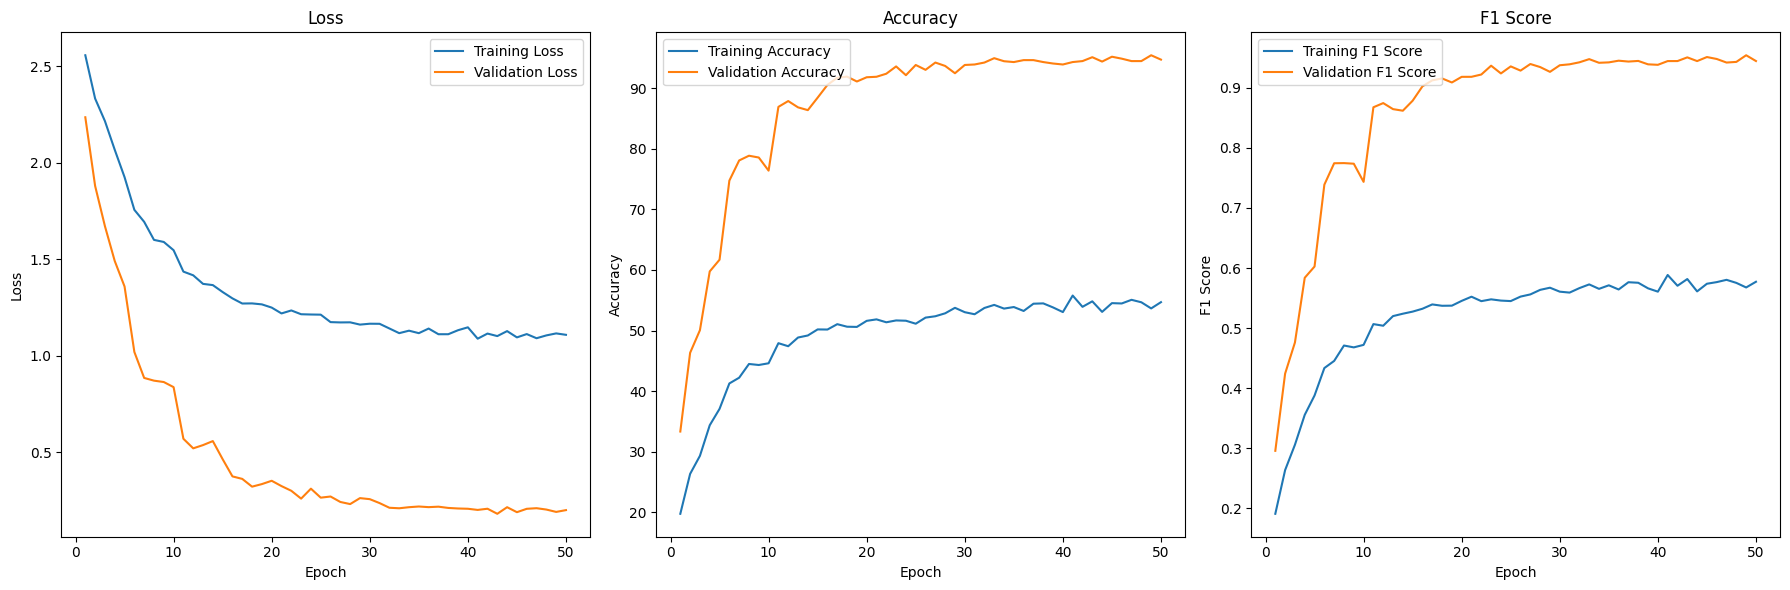

In [20]:
# Plotting the loss, accuracy, and F1 score
actual_epochs = len(train_loss)

epochs_range = range(1, actual_epochs + 1)

plt.figure(figsize=(18, 6))

# Plot training & validation loss values
plt.subplot(1, 3, 1)
plt.plot(epochs_range, train_loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

# Plot training & validation accuracy values
plt.subplot(1, 3, 2)
plt.plot(epochs_range, train_accuracy, label='Training Accuracy')
plt.plot(epochs_range, val_accuracy, label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')

# Plot training & validation F1 score values
plt.subplot(1, 3, 3)
plt.plot(epochs_range, train_f1_score, label='Training F1 Score')
plt.plot(epochs_range, val_f1_score, label='Validation F1 Score')
plt.title('F1 Score')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

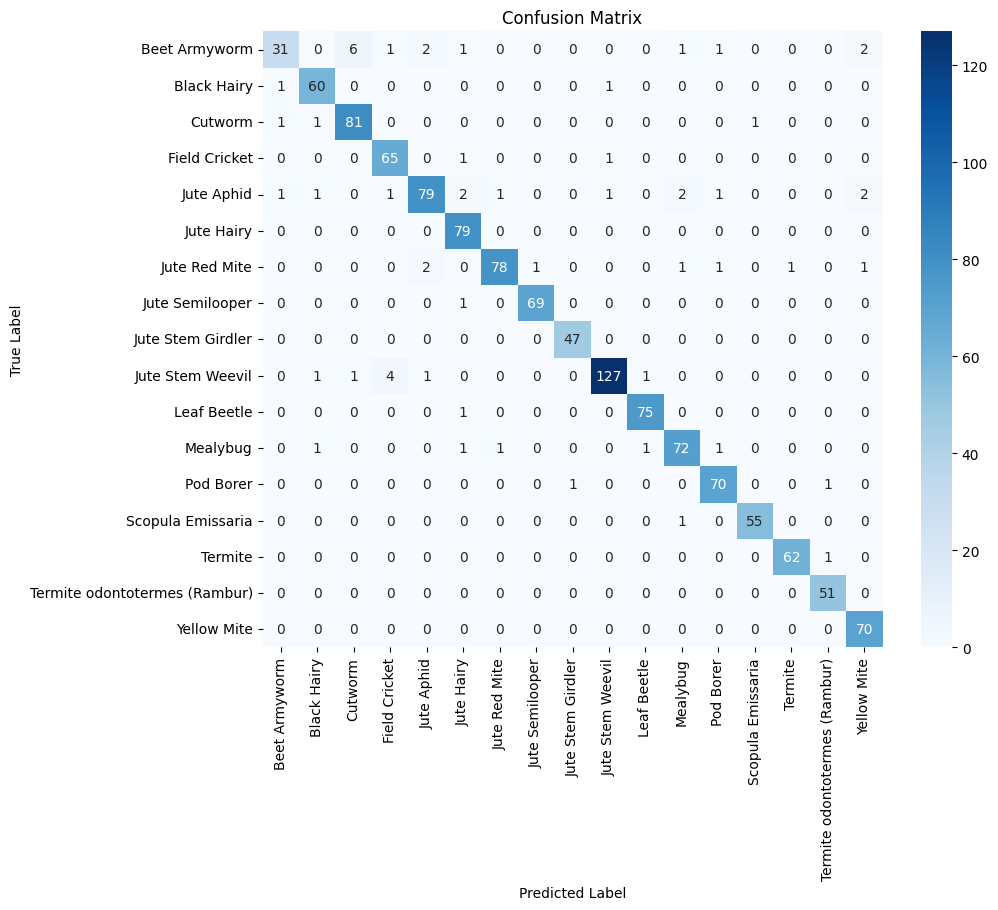

Classification Report:
                               precision    recall  f1-score   support

                Beet Armyworm       0.91      0.69      0.78        45
                  Black Hairy       0.94      0.97      0.95        62
                      Cutworm       0.92      0.96      0.94        84
                Field Cricket       0.92      0.97      0.94        67
                   Jute Aphid       0.94      0.87      0.90        91
                   Jute Hairy       0.92      1.00      0.96        79
                Jute Red Mite       0.97      0.92      0.95        85
              Jute Semilooper       0.99      0.99      0.99        70
            Jute Stem Girdler       0.98      1.00      0.99        47
             Jute Stem Weevil       0.98      0.94      0.96       135
                  Leaf Beetle       0.97      0.99      0.98        76
                     Mealybug       0.94      0.94      0.94        77
                    Pod Borer       0.95      0.97   

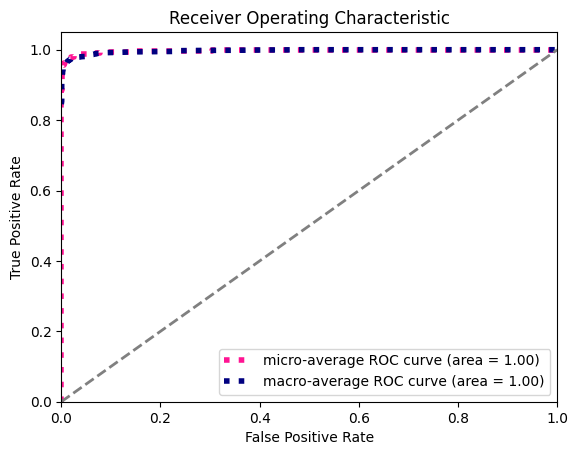

In [21]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np
import torch

# Fungsi untuk menghitung confusion matrix
def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title('Confusion Matrix')
    plt.show()

# Evaluasi tambahan setelah training selesai
def evaluate_model(model, dataloader, classes):
    model.eval()
    true_labels = []
    pred_labels = []
    logits_list = []

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)  # Asumsi outputs adalah tensor logits langsung
            logits_list.append(outputs.cpu().numpy())
            _, preds = torch.max(outputs, 1)
            true_labels.extend(labels.cpu().numpy())
            pred_labels.extend(preds.cpu().numpy())

    logits_array = np.concatenate(logits_list, axis=0)
    true_labels = np.array(true_labels)
    pred_labels = np.array(pred_labels)

    # Binarize the labels for ROC calculation
    true_labels_binarized = label_binarize(true_labels, classes=range(len(classes)))

    # Plot confusion matrix
    plot_confusion_matrix(true_labels, pred_labels, classes)

    # Classification report
    print("Classification Report:")
    print(classification_report(true_labels, pred_labels, target_names=classes, zero_division=1))

    # ROC Curve and AUC for multi-class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(len(classes)):
        fpr[i], tpr[i], _ = roc_curve(true_labels_binarized[:, i], logits_array[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(true_labels_binarized.ravel(), logits_array.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Compute macro-average ROC curve and ROC area
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(len(classes))]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(len(classes)):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

    mean_tpr /= len(classes)
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot ROC curves
    plt.figure()
    plt.plot(fpr["micro"], tpr["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'.format(roc_auc["micro"]),
             color='deeppink', linestyle=':', linewidth=4)

    plt.plot(fpr["macro"], tpr["macro"],
             label='macro-average ROC curve (area = {0:0.2f})'.format(roc_auc["macro"]),
             color='navy', linestyle=':', linewidth=4)

    plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

# Evaluasi pada dataset validation setelah training selesai
evaluate_model(model, val_loader, classes=label_encoder.classes_)


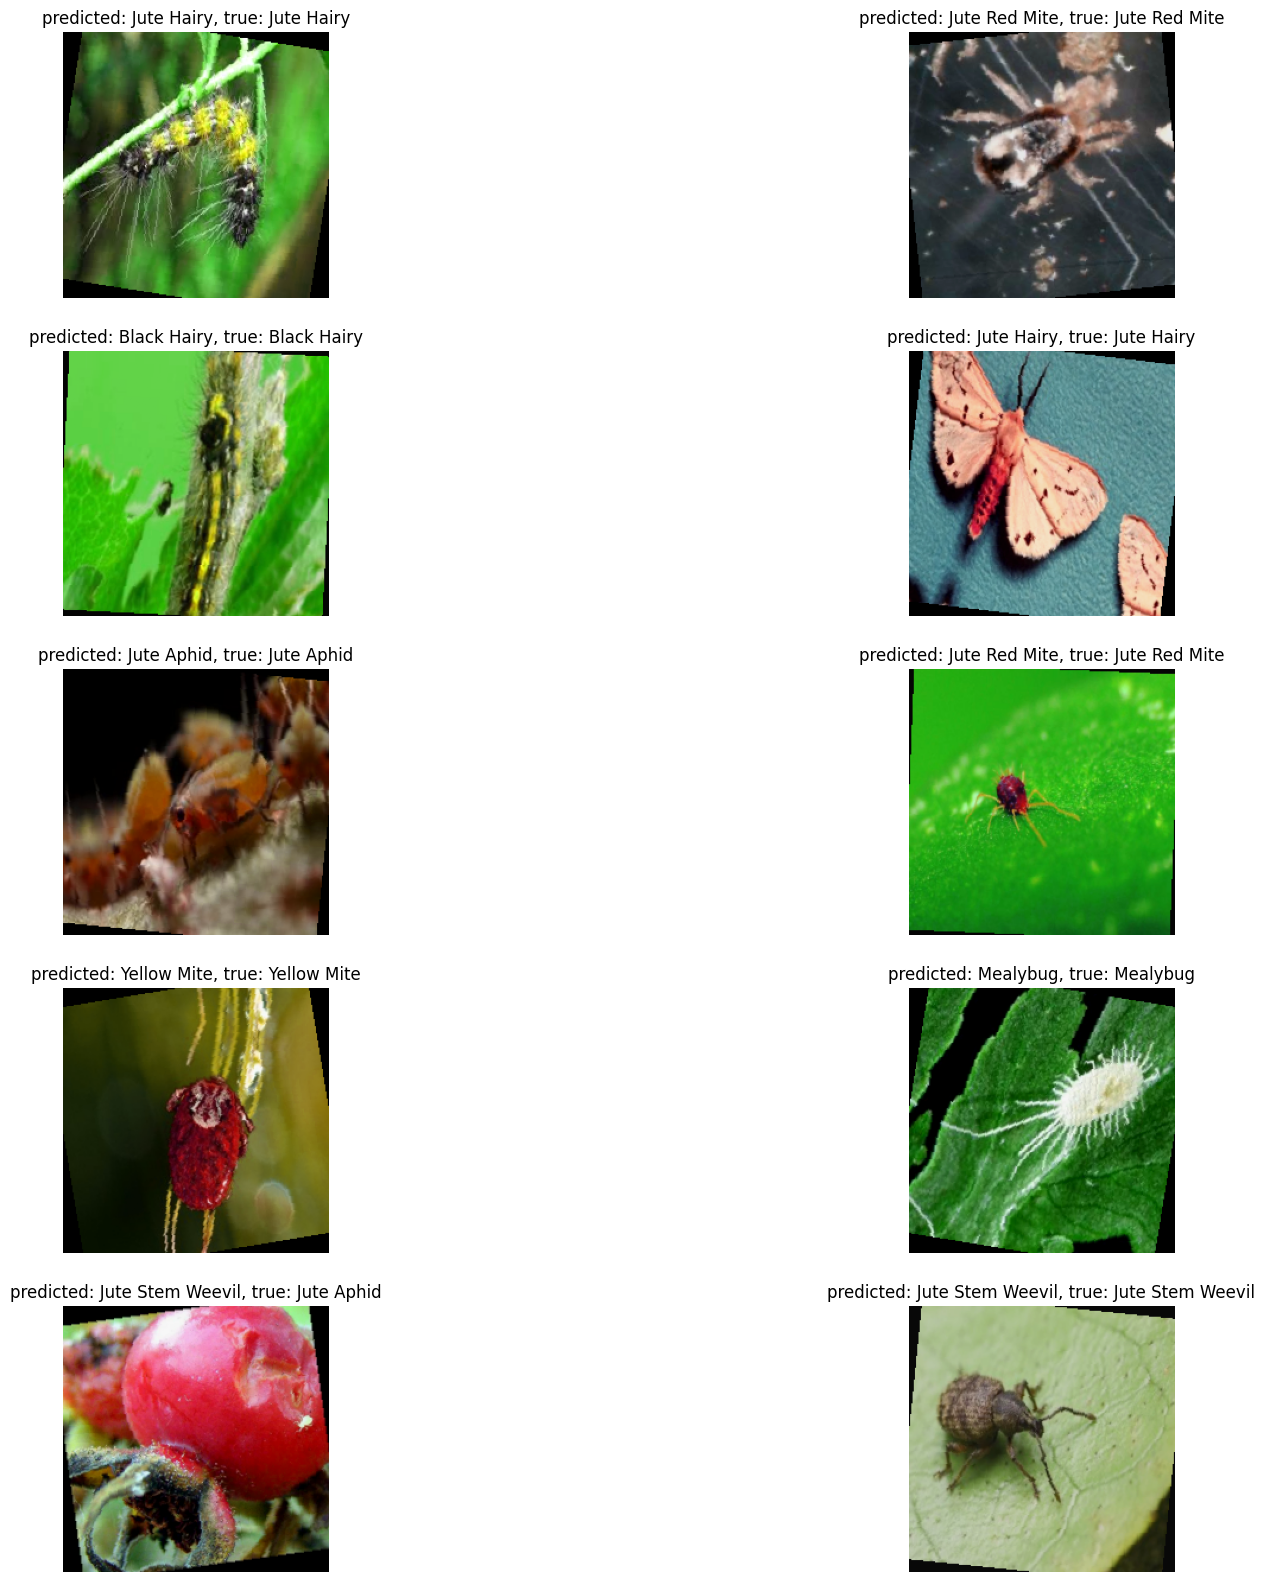

In [22]:
# Visualisasi prediksi pada dataset validation
def visualize_predictions(model, dataloader, classes, num_images=10):
    model.eval()
    images_so_far = 0
    fig = plt.figure(figsize=(20, 20))

    with torch.no_grad():
        for i, (images, labels) in enumerate(dataloader):
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            for j in range(images.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images // 2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {classes[preds[j]]}, true: {classes[labels[j]]}')
                plt.imshow(images.cpu().data[j].permute(1, 2, 0))

                if images_so_far == num_images:
                    model.train(mode=True)
                    return
        model.train(mode=True)

# Visualisasi beberapa prediksi pada dataset validation
visualize_predictions(model, val_loader, classes=label_encoder.classes_, num_images=10)


In [23]:
# Define the test dataset class
class TestJutePestDataset(Dataset):
    def __init__(self, dataframe, img_dir, transform=None):
        self.dataframe = dataframe
        self.img_dir = img_dir
        self.transform = transform
    
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir, self.dataframe.iloc[idx, 1])
        image = Image.open(img_name).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        return image

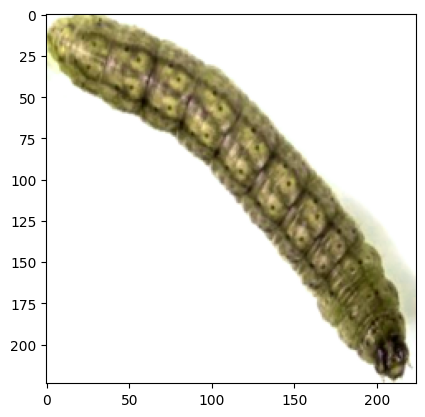

In [24]:
# Load and prepare test dataset
test_dir = '/kaggle/input/jutepest/test_images/'
test_csv = pd.read_csv('/kaggle/input/jutepest/test.csv')
test_dataset = TestJutePestDataset(test_csv, test_dir, transform)
plt.imshow(torch.permute(test_dataset[0], (1, 2, 0)))
plt.show()

In [25]:
# Create DataLoader for test dataset
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [26]:
# Function for making predictions
def predict(model, test_loader):
    model.eval()
    predictions = []
    
    with torch.no_grad():
        for images in test_loader:
            images = images.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            predictions.extend(predicted.cpu().numpy())
    
    return predictions


In [27]:
# Make predictions on test dataset
predictions = predict(model, test_loader)
predicted_labels = label_encoder.inverse_transform(predictions)

In [28]:
# Prepare submission file
test = pd.read_csv('/kaggle/input/jutepest/test.csv')
sub = pd.concat([test.id, pd.DataFrame(predicted_labels, columns=['class'])], axis=1)
sub.set_index('id', inplace=True)
sub.to_csv("submission_xception_final.csv")
sub

,class
id,
0,Cutworm
1,Jute Hairy
2,Black Hairy
3,Field Cricket
4,Black Hairy
...,...
1081,Termite
1082,Jute Hairy
1083,Jute Stem Girdler
